# Object Detection with RT-DETR + Segmentation with SAM2.1

This notebook demonstrates:
1. Object detection using RT-DETR
2. Object segmentation using SAM2.1 starting from the boxes found by RF-DETR

## Helper functions

Let's start by defining some helper functions:

In [ ]:
import torch
from typing import List
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image

# Only needed on the Udacity workspace. Comment this out if running on another system.
import os
os.environ['HF_HOME'] = '/voc/data/huggingface'
os.environ['OLLAMA_MODELS'] = '/voc/data/ollama/cache'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['PATH'] = f"/voc/data/ollama/bin:/voc/data/ffmpeg/bin:{os.environ.get('PATH', '')}"
os.environ['LD_LIBRARY_PATH'] = f"/voc/data/ollama/lib:/voc/data/ffmpeg/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"


def get_distinct_colors(n_colors):
    if n_colors <= 10:
        cmap = plt.cm.tab10
    elif n_colors <= 20:
        cmap = plt.cm.tab20
    else:
        cmap = plt.cm.tab20
        # Cycle through colors if more than 20

    colors = [cmap(i % cmap.N) for i in range(n_colors)]
    return colors


def visualize_detr_detections(
    image: Image.Image,
    boxes: torch.Tensor,
    scores: torch.Tensor,
    labels: torch.Tensor,
    class_labels: List[str],
):
    """
    Visualize DETR detections with bounding boxes, confidence scores, and labels.
    """

    # Visualize detections
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image, mode='RGBA')

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.tolist()
        label_id = int(label.item())

        # Draw bounding box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=1)

        # Draw label and confidence score
        class_name = class_labels[label_id]
        text = f"{class_name}: {score:.2f}"
        draw.text((x1, y1 - 20), text, fill="red")

    fig, sub = plt.subplots(figsize=(12, 8))
    sub.imshow(draw_image)
    sub.set_title("RF-DETR Detections")
    sub.axis("off")

    plt.show(fig)

## Load Object Detection model

Here we load the RT-DETR model, one of the state-of-the-art real-time object detection models capable of running at several Hz (so useful also for video and real-time detection):

In [ ]:
from transformers import (
    RTDetrImageProcessor,
    RTDetrV2ForObjectDetection,
)

# Load RT-DETR model
detr_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_v2_r50vd")
detr_model = RTDetrV2ForObjectDetection.from_pretrained("PekingU/rtdetr_v2_r50vd")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

Model loaded successfully


## Load Sample Image

Let's now load a sample image. For simplicity, let's get the first image of the COCO validation set:

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

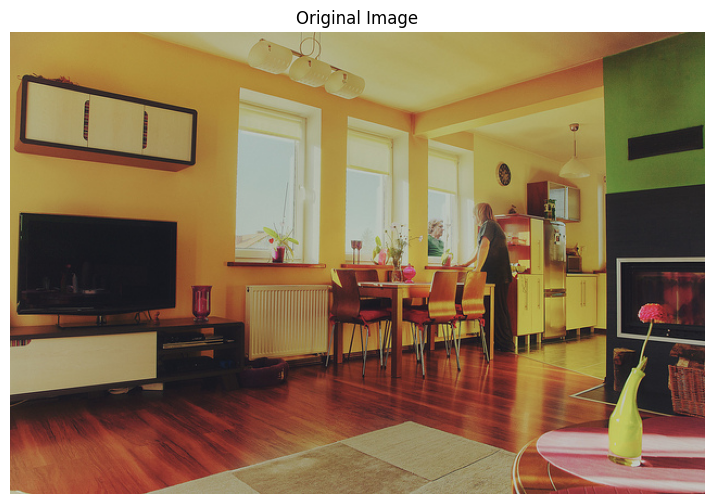

In [8]:
from datasets import load_dataset

# Load a sample image from COCO dataset
dataset = load_dataset("detection-datasets/coco", split="val", streaming=True)
sample = next(iter(dataset))
image = sample["image"]

# Display original image
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()

## Step 1: Object Detection with RT-DETR

Ok, now that we have data and model, let's run it:

Detected 21 objects


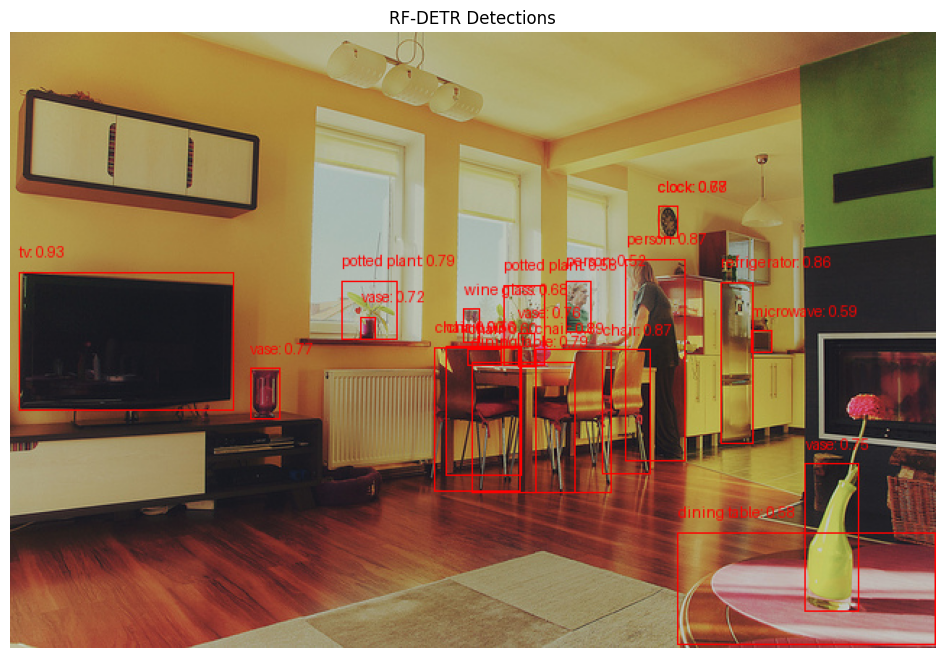

In [9]:
# Process image for RF-DETR
inputs = detr_processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = detr_model(**inputs)

# Post-process results
results = detr_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=0.5
)

# Extract detection results
boxes = results[0]["boxes"]
scores = results[0]["scores"]
labels = results[0]["labels"]

print(f"Detected {len(boxes)} objects")
visualize_detr_detections(image, boxes, scores, labels, dataset.info.features['objects']['category'].feature.names)

## Step 2: Segmentation with SAM2.1

With the object detection results in hand, let's move to the segmentation part. We can pass the boxes directly to SAM 2.1 and get the segmentation mask for each one of the detected objects:

In [ ]:
from transformers import Sam2Processor, Sam2Model
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-base-plus").to(device)
processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-base-plus")

inputs = processor(
    images=image,
    input_boxes=[boxes],
    return_tensors="pt",
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"]
)[0]

# Get IoU scores to select best mask for each box
iou_scores = outputs.iou_scores.cpu()

# Select the best mask for each box based on highest IoU score
best_masks = []
for i in range(masks.shape[0]):  # For each of the boxes
    best_mask_idx = torch.argmax(iou_scores[0, i])  # Get index of best mask
    best_mask = masks[i, best_mask_idx]  # Select the best mask
    best_masks.append(best_mask)

best_masks = torch.stack(best_masks)  # Shape: [n_objects, image height, image width]
print(f"Best masks shape: {best_masks.shape}")

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Best masks shape: torch.Size([21, 426, 640])


## Step 3: Plot results

Now that we have everything, let's see what we got! To make things a little easier to see, we will convert the original image to grayscale:

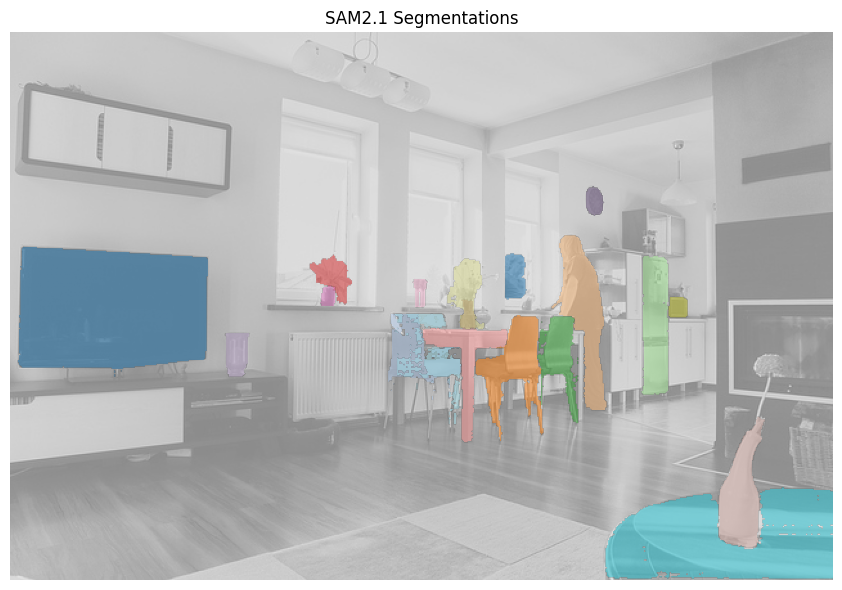

In [13]:
import numpy as np


# Visualize combined detection + segmentation
fig, sub = plt.subplots(1, 1, figsize=(18, 6))

# Show image, but let's convert it to grayscale first so
# the segmentation masks are going to be easier to see
sub.imshow(image.convert("L").convert("RGB"), alpha=0.5)

colors = get_distinct_colors(len(best_masks))

for i, mask in enumerate(best_masks):
    # Create colored overlay using optimal colors
    colored_mask = np.zeros((*mask.shape, 4))

    # Get RGB values from the colormap (first 3 values are R, G, B)
    color_rgb = colors[i][:3]

    # Apply the color to the mask
    colored_mask[mask > 0, :3] = color_rgb  # RGB channels
    colored_mask[mask > 0, 3] = 0.5  # Alpha channel

    sub.imshow(colored_mask)

sub.set_title("SAM2.1 Segmentations")
sub.axis("off")

plt.tight_layout()
plt.show()